## Data Preparation

In [1]:
import pandas as pd

In [2]:
movies_data_path = '../dataset/movies.csv'
finantial_data_path = '../dataset/finantials.csv'
opening_data_path = '../dataset/opening_gross.csv'

In [3]:
fin_data = pd.read_csv(finantial_data_path)
movie_data = pd.read_csv(movies_data_path)
opening_data = pd.read_csv(opening_data_path)

In [4]:
numeric_columns_mask = (movie_data.dtypes == float) | (movie_data.dtypes == int)
numeric_columns = [column for column in numeric_columns_mask.index if numeric_columns_mask[column]]
movie_data = movie_data[numeric_columns+['movie_title']]

In [5]:
fin_data = fin_data[['movie_title','production_budget','worldwide_gross']]

In [6]:
fin_movie_data = pd.merge(fin_data, movie_data, on= 'movie_title', how='left')

In [7]:
full_movie_data = pd.merge( opening_data,fin_movie_data, on = 'movie_title', how='left')

In [8]:
full_movie_data[(full_movie_data.worldwide_gross != 0) & (full_movie_data.worldwide_gross.notnull())].shape

(2304, 12)

In [9]:
full_movie_data = full_movie_data.drop(['movie_title','gross'],axis=1)

In [10]:
full_movie_data.columns

Index(['opening_gross', 'screens', 'production_budget', 'worldwide_gross',
       'title_year', 'aspect_ratio', 'duration', 'cast_total_facebook_likes',
       'budget', 'imdb_score'],
      dtype='object')

## Modeling

In [11]:
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt


In [12]:
full_movie_data_scaled = full_movie_data.copy()

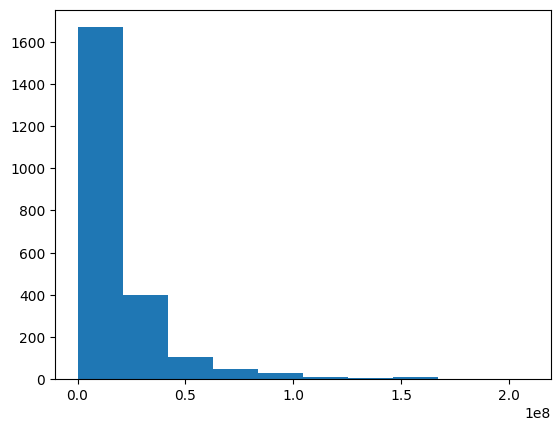

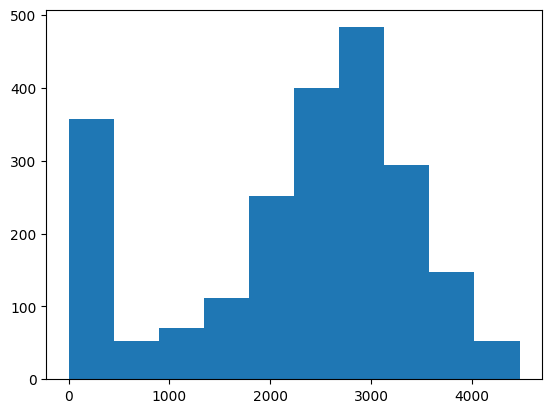

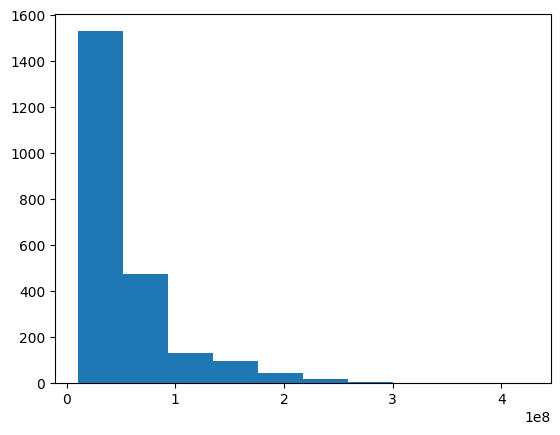

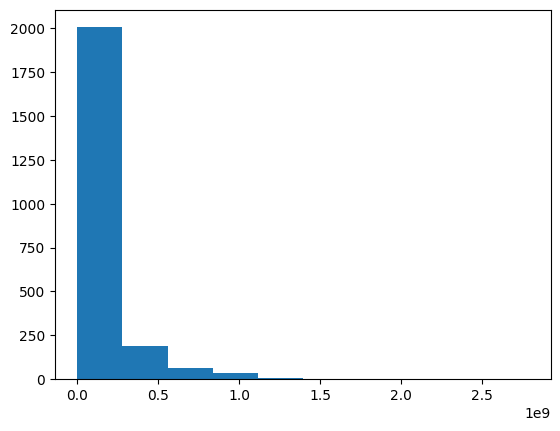

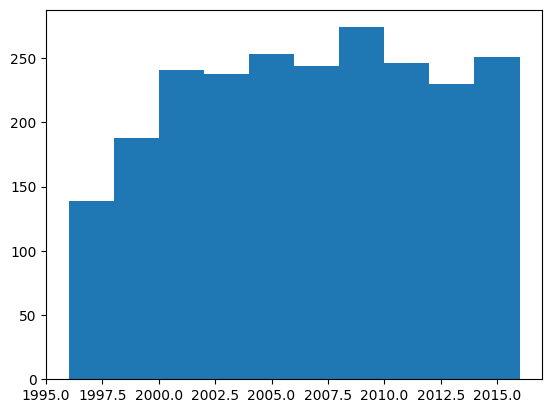

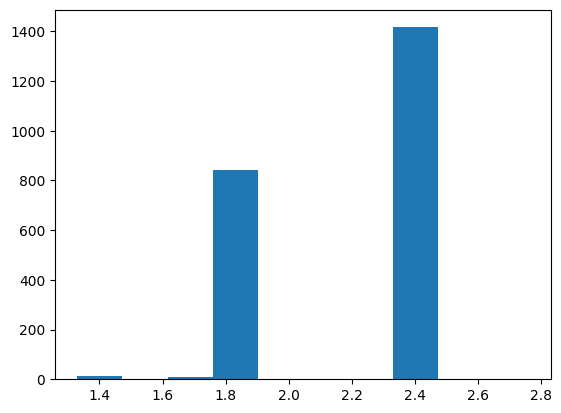

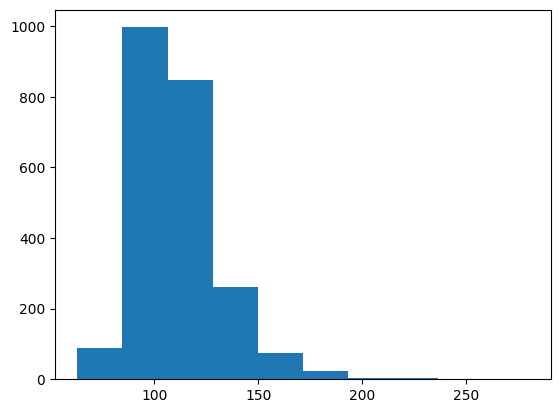

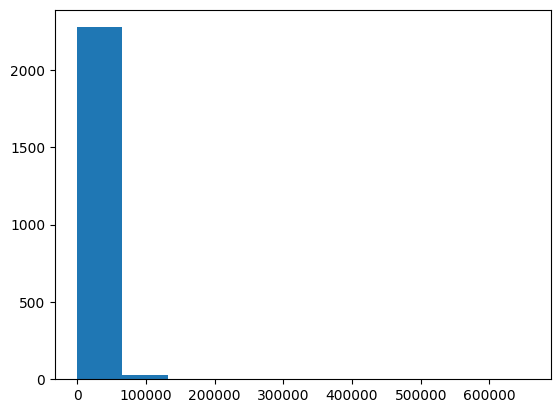

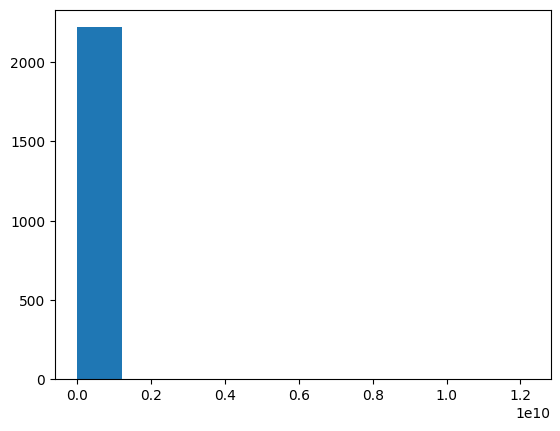

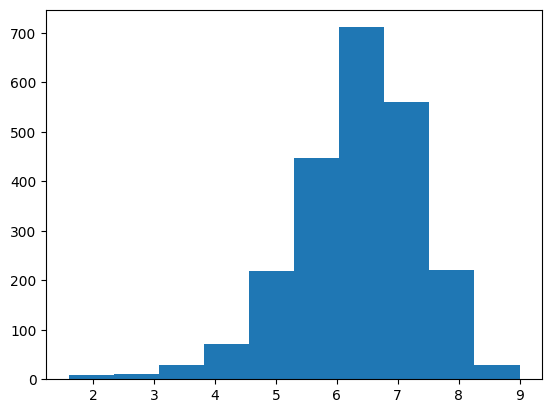

In [13]:
for column in full_movie_data_scaled.columns:
    plt.hist(full_movie_data_scaled[column])
    plt.show() 

In [14]:
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method='box-cox')
full_movie_data_scaled = scaler.fit_transform(full_movie_data_scaled)
full_movie_data_scaled = pd.DataFrame(full_movie_data_scaled, columns = full_movie_data.columns)

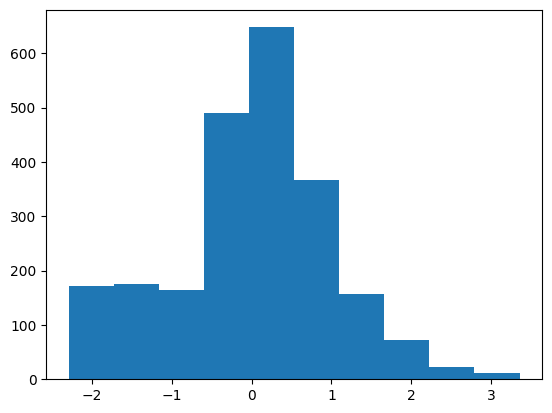

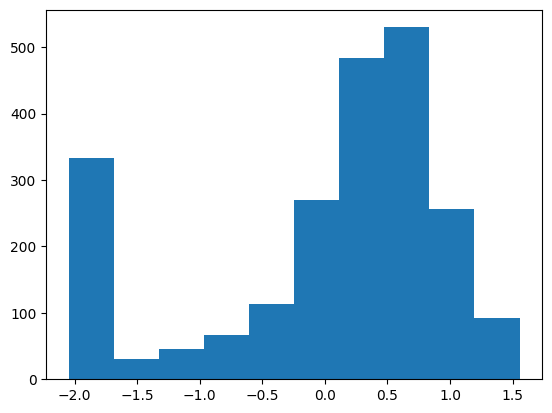

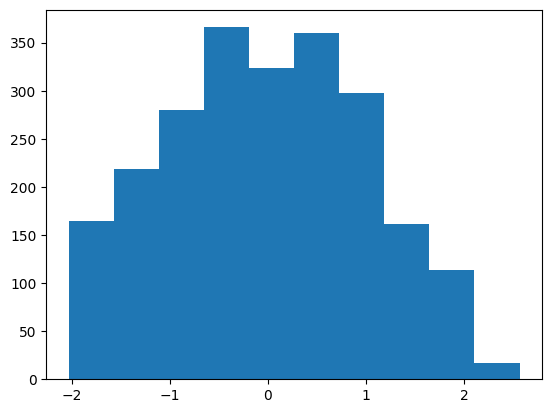

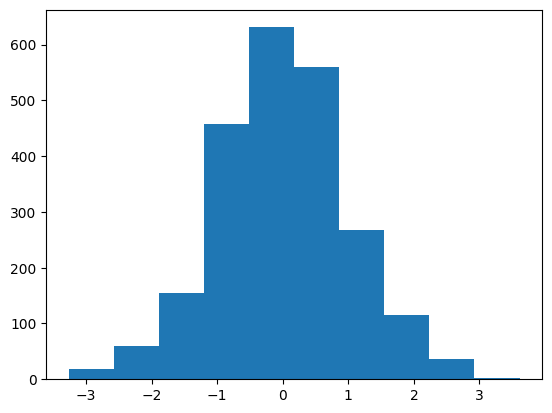

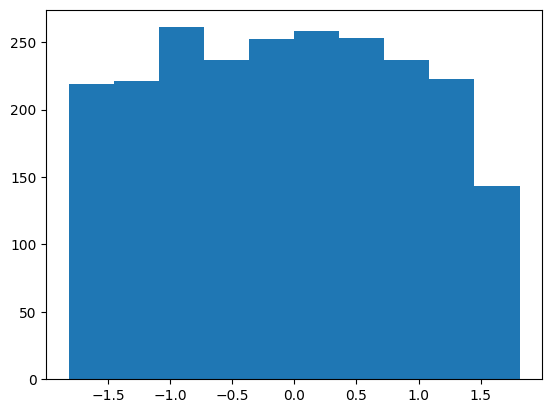

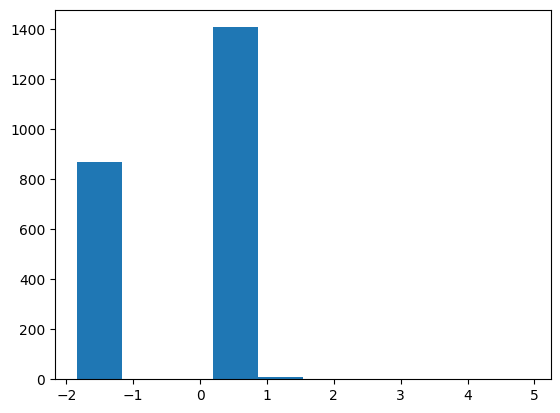

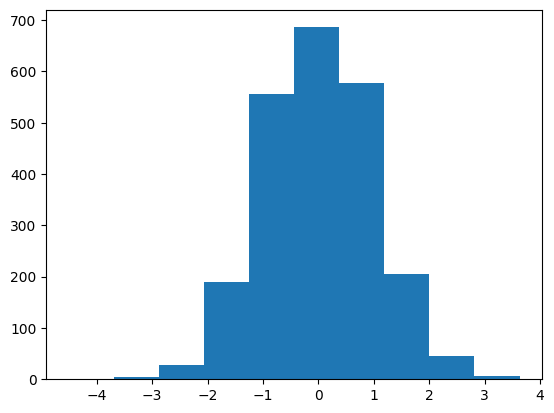

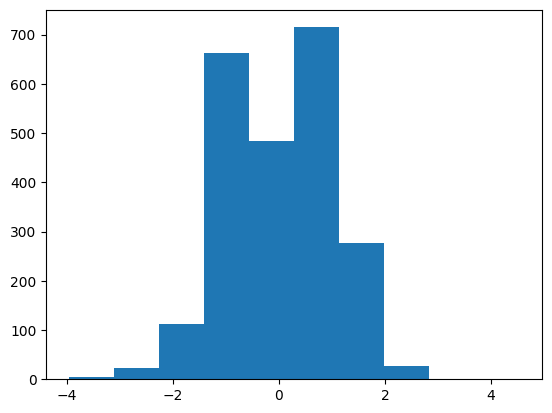

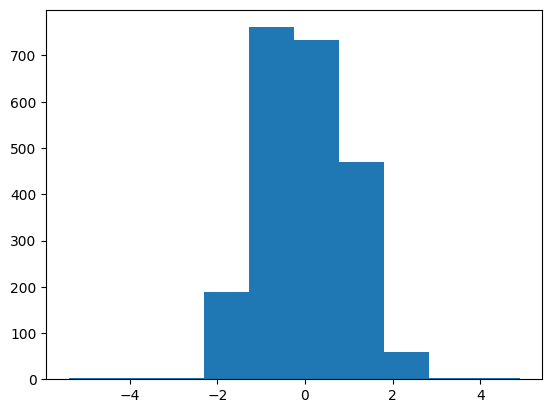

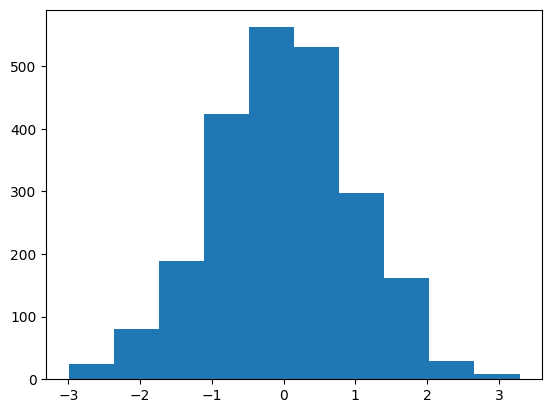

In [15]:
for column in full_movie_data_scaled.columns:
    plt.hist(full_movie_data_scaled[column])
    plt.show() 

In [16]:
X = full_movie_data_scaled.drop(['worldwide_gross'], axis = 1)
y = full_movie_data_scaled['worldwide_gross']

In [17]:

test_size = 0.20
imputer = KNNImputer(missing_values=np.nan)
cv = ShuffleSplit(n_splits=10, test_size=test_size, random_state=42)

pipeline = Pipeline([
    # ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('imputer', imputer),
    ('core_model', GradientBoostingRegressor())
])

In [18]:
results = cross_validate(pipeline, X, y, return_train_score=True, cv=cv, n_jobs=-1)
results

{'fit_time': array([0.67579699, 0.71734715, 0.69252396, 0.67961407, 0.64833832,
        0.67481828, 0.42626953, 0.39420509, 0.37827611, 0.35928226]),
 'score_time': array([0.02432108, 0.01579022, 0.01809812, 0.0216372 , 0.01548934,
        0.01565933, 0.00815487, 0.00726151, 0.00756717, 0.00714803]),
 'test_score': array([0.80542351, 0.83220501, 0.77478481, 0.82481551, 0.79360977,
        0.80671526, 0.770084  , 0.801878  , 0.80453286, 0.81300418]),
 'train_score': array([0.88737697, 0.88190561, 0.88768842, 0.88421199, 0.8902024 ,
        0.88189585, 0.88680004, 0.88717785, 0.88482324, 0.88758098])}

In [19]:
train_score = np.mean(results['train_score'])
test_score = np.mean(results['test_score'])
assert train_score > 0.7
assert test_score > 0.65
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

Train Score: 0.8859663346394487
Test Score: 0.8027052909239407


## Hyperparameter tunning

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
param_tunning = {'core_model__n_estimators': range(20,501,20)} 

In [22]:
estimator = Pipeline([
    ('imputer', imputer),
    ('core_model', GradientBoostingRegressor())
])

In [23]:
grid_search= GridSearchCV(estimator,
                       param_grid = param_tunning,
                       scoring='r2',
                       cv=cv,
                       n_jobs=-1) 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)

In [25]:
grid_search.fit(X_train, y_train)

print(f'\t├──{grid_search.best_estimator_ = }')
print(f'\t├──{grid_search.best_score_ = } \n\n')

	├──grid_search.best_estimator_ = Pipeline(steps=[('imputer', KNNImputer()),
                ('core_model', GradientBoostingRegressor(n_estimators=280))])
	├──grid_search.best_score_ = 0.8092504554378623 




In [26]:
final_result = cross_validate(grid_search.best_estimator_, X_train, y_train, return_train_score=True, cv=cv, n_jobs=-1)

In [27]:
train_score = np.mean(final_result['train_score'])
test_score = np.mean(final_result['test_score'])
assert train_score > 0.7
assert test_score > 0.65
print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

Train Score: 0.9359174751543063
Test Score: 0.8090649617523203


In [28]:
grid_search.best_estimator_.get_params()

{'memory': None,
 'steps': [('imputer', KNNImputer()),
  ('core_model', GradientBoostingRegressor(n_estimators=280))],
 'verbose': False,
 'imputer': KNNImputer(),
 'core_model': GradientBoostingRegressor(n_estimators=280),
 'imputer__add_indicator': False,
 'imputer__copy': True,
 'imputer__keep_empty_features': False,
 'imputer__metric': 'nan_euclidean',
 'imputer__missing_values': nan,
 'imputer__n_neighbors': 5,
 'imputer__weights': 'uniform',
 'core_model__alpha': 0.9,
 'core_model__ccp_alpha': 0.0,
 'core_model__criterion': 'friedman_mse',
 'core_model__init': None,
 'core_model__learning_rate': 0.1,
 'core_model__loss': 'squared_error',
 'core_model__max_depth': 3,
 'core_model__max_features': None,
 'core_model__max_leaf_nodes': None,
 'core_model__min_impurity_decrease': 0.0,
 'core_model__min_samples_leaf': 1,
 'core_model__min_samples_split': 2,
 'core_model__min_weight_fraction_leaf': 0.0,
 'core_model__n_estimators': 280,
 'core_model__n_iter_no_change': None,
 'core_model

In [29]:
estimator = Pipeline([
    ('imputer', imputer),
    ('core_model',  GradientBoostingRegressor(n_estimators=245,
                                             ccp_alpha=0.0,
                                             criterion='friedman_mse',
                                             init=None,
                                             learning_rate=0.017,
                                             loss='huber',
                                             max_depth=2,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_samples_leaf=3,
                                             min_samples_split=3,
                                             min_weight_fraction_leaf=0.0,
                                             n_iter_no_change=None,
                                             random_state=None,
                                             subsample=1,
                                             tol=0.0001,
                                             validation_fraction=0.1,
                                             verbose=0,
                                             warm_start=False))
])

In [30]:
estimator.fit(X_train,y_train)

Pipeline(steps=[('imputer', KNNImputer()),
                ('core_model',
                 GradientBoostingRegressor(learning_rate=0.017, loss='huber',
                                           max_depth=2, min_samples_leaf=3,
                                           min_samples_split=3,
                                           n_estimators=245, subsample=1))])

In [31]:
print(estimator.score(X_test, y_test))
print(estimator.score(X_train,y_train))
print(estimator.score(X_train,y_train)-estimator.score(X_test, y_test))


0.7818083247297987
0.8049851591190109
0.023176834389212253


## Saving model

In [32]:
from joblib import dump

In [33]:
dump(estimator, '../model/model.pkl')

['../model/model.pkl']

In [34]:
X_train.columns

Index(['opening_gross', 'screens', 'production_budget', 'title_year',
       'aspect_ratio', 'duration', 'cast_total_facebook_likes', 'budget',
       'imdb_score'],
      dtype='object')

In [54]:
import json

xsamples = X_test.sample(3, random_state=42)
xsamples = xsamples.to_dict(orient="index")

ysample = pd.DataFrame(y_test.sample(3, random_state=42))
ysample.columns = ["worldwide_gross"]
ysample = ysample.to_dict(orient="index")


with open('../api/sample_to_test_API.txt', 'w') as convert_file:
    convert_file.write("Tomamos 3 muestras aleatorias con la misma seed para hacer un test del modelo en FastAPI \n \n")
    convert_file.write("# input dict: \n")
    for number_sample, value_x_sample in xsamples.items():
        convert_file.write(f'Sample number: {number_sample}' + '\n' + json.dumps(value_x_sample) + "\n\n")
    convert_file.write("# output dict: \n")
    for number_sample, value_y_sample in ysample.items():
        convert_file.write(f'Sample number: {number_sample}' + '\n' + json.dumps(value_y_sample) + "\n\n")